| Name | Admin No | Class | Assignment |
| --- | --- | --- | --- |
| Goh Rui Zhuo | 2222329 | DAAA/2B/05 | Deep Learning CA1 |

# __Part A: Convolutional Neural Network__

<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Problem Statement and Background Research__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">


The goal of this part is to implement an image classifier using deep learning network:

- Dataset contains 15 types of vegetables
- Colour must be converted into grayscale
- Two Models must be developed
    1. 31 x 31
    2. 128 x 128

Build two models and compare the accuracies for each ones


__What is image classification ?__
Image classification stands out with its irreplaceable role in modern technology. It involves assigning a label or tag to an entire image based on preexisting training data of already labeled image

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__References__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

1. https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
2. https://towardsdatascience.com/everything-you-need-to-know-about-activation-functions-in-deep-learning-models-84ba9f82c253

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Import Libraries__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import all the required libraries

In [14]:
!pip install tensorflow_addons keras-tuner pandas matplotlib seaborn scikit-learn tqdm

### Other Imports

In [15]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, accuracy_score

import os, time, math, datetime, warnings, pytz, glob
from IPython.display import display
from functools import reduce
import absl.logging
from tqdm import tqdm
import logging

absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings('ignore')

### Tensorflow Import

In [16]:
import tensorflow as tf

from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow import expand_dims
from tensorflow.keras import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Input, InputLayer, Normalization, Flatten,BatchNormalization,
    Dropout,Conv2D, GlobalAveragePooling2D, MaxPooling2D, ReLU, Layer,Activation, Multiply, AveragePooling2D,
    Add, RandomRotation,Resizing, Rescaling, Reshape, Concatenate, concatenate, Lambda,LeakyReLU)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN, TensorBoard, CSVLogger, Callback
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad, Adamax
from tensorflow.keras.regularizers import l2, L2
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.metrics import FalseNegatives, categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import *
from tensorflow_addons.optimizers import SWA


from kerastuner.tuners import Hyperband
from kerastuner import HyperModel
# Setting a seaborn style
sns.set(style="whitegrid")


### Set the seed of this notebook

In [17]:
seed = 32
tf.random.set_seed(seed)
np.random.seed(seed)

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Check for GPU__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is check the available GPUs and set the memory growth

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [19]:
!nvidia-smi

Tue Nov 28 00:23:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.34                 Driver Version: 537.34       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P8               5W /  92W |    924MiB /  8188MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Import dataset__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import the dataset and proceed to do Exxploratory Data Analysis

### Train Data

In [20]:
data = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/train'  ,
                                                   color_mode='rgb',    label_mode='categorical',
                                                   image_size=(224,224))
data

Found 9028 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
 - From the above dataset, we can see that the iamges contains 9028 files with 15 classes<
</div>

### Validation Data

In [21]:
val_data = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/validation'  ,
                                                       color_mode = 'rgb',    label_mode='categorical',
                                                       image_size=(224,224) )
val_data

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
 
- From the above dataset, we can see that the iamges contains 3000 files with 15 classes
</div>

### Test Data

In [22]:
test_data = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/test'  ,
                                                       color_mode = 'rgb',    label_mode='categorical',
                                                       image_size=(224,224) )
test_data

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

   - From the above dataset, we can see that the iamges contains 3000 files with 15 classes
</div>

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Setting the Data__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here we will set the data to X and y for ease of feature engineering later on

### Train Data

In [23]:
X_train = []
y_train = []

# This gets all the images data into the array
for images, labels in tqdm(data):
    X_train.append(images)
    y_train.append(labels)

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

100%|██████████| 283/283 [00:01<00:00, 141.88it/s]


#### Checking the data shapes

In [24]:
(X_train.shape, y_train.shape)

((9028, 224, 224, 3), (9028, 15))

### Validation Data

In [25]:
X_val = []
y_val = []

# This gets all the images data into the array
for images, labels in tqdm(val_data):
    X_val.append(images)
    y_val.append(labels)

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

100%|██████████| 94/94 [00:00<00:00, 147.51it/s]


#### Checking the data shapes

In [26]:
(X_val.shape, y_val.shape)

((3000, 224, 224, 3), (3000, 15))

### Test Data

In [27]:
X_test = []
y_test = []

# This gets all the images data into the array
for images, labels in tqdm(test_data):
    X_test.append(images)
    y_test.append(labels)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

100%|██████████| 94/94 [00:00<00:00, 124.34it/s]


#### Checking the data shapes

In [28]:
(X_test.shape, y_test.shape)

((3000, 224, 224, 3), (3000, 15))

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
 - Data is split into X and y for train, validation and test succesfully
</div>

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Exploratory Data Analysis (Original Image)__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import the dataset and proceed to do analysis on it

### Set the labels for the Classes

This is so that we are able to use it for EDA and model training later on

In [29]:
labels_dict = os.listdir('Dataset for CA1 part A/train')
labels_dict = {idx: label for idx, label in enumerate(labels_dict)}
print(labels_dict)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


### Class Distribution

The idea here is to identify class imbalance throughout the dataset 
as imbalance dataset may cause poor performance for the class with less representation, impacting overall performance

In [30]:
def get_classes_distribution(data, labels_dict):
    label_counts = {vegetable: 0 for vegetable in labels_dict.values()}
    total_samples = 0

    for batch in tqdm(data):
        labels = batch[1]
        unique_labels, counts = tf.unique(labels)
        for label, count in zip(unique_labels.numpy(), counts.numpy()):
            vegetable = labels_dict.get(label, "Unknown")
            label_counts[vegetable] += count
            print(f"Debug: Label {label} ({vegetable}) -> Count: {count}")  # Debug print

        total_samples += len(labels)

    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        print("Label {} contains: {} samples, {:.2f}%".format(label, count, percent))

    return label_counts

In [44]:
total_batches = 0
total_samples = 0

for batch in train_ds:
    total_batches += 1
    # Each batch is a tuple (images, labels), so we count the number of labels
    total_samples += batch[1].shape[0]

print(f"Total number of batches: {total_batches}")
print(f"Total number of samples: {total_samples}")

Total number of batches: 71
Total number of samples: 9028


In [50]:
# Assuming 'dataset' is your TensorFlow dataset
class_counts = {}

for _, labels in train_ds:
    # Convert labels to numpy array and flatten (if needed)
    labels = labels.numpy().flatten()
    print(labels)
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

# Print to verify
print(class_counts)

[14  6 14  4  8  0 14  4 14  4 12  7 12  9 12 14 14 12  0 12 13 14 12  9
 10 14  1 14  5  3  2 10  4  0  5  2  1 13 10  1  2  8  4  0  1  0  3 14
 11  4  1 10  4 11  7 11  4 14  3  0 10  4  0  0  5 10  4 14  8  9  2  7
  8  0 14  0 11  8  0  4 11 12  5  4 14  3  8  9  2 14 14  6 14  1 14  9
 10 13 14  3 14  9  7 12 12 13  3  3 13 12  6  6 13  8 10 14 13  8  2  0
 11  9  2  4  0  7 14 14]
[10  0  9 13 11  3 14  5 12  8 12  5  8  3 14  0  3  3  2 12  9  5  4  0
  9  7 14  3  3 13 12 10  0 14 14  1 10  0  5  2  3  4 12  3  8  3 14  5
 14  5  2  4  2  0  3  4 11  9  3  2  9  3  3 12  3  4 11  2  4  8  5  8
 14  4 10 12 14  5  4  5  0  8  1  0  5  0  4  3 12  3 10  3 14  0  0 12
 12 12  0  9  3  9 11  7  9 12 14  2 13  1 14  1 14 11  8  6  9  9 12  8
  0 10 14  5 12  1 10 10]
[ 3  9 12  0 13  9  4  3  0  5  3 12  0  8  8 14  0 14 12 14  8  6  9 13
  4  8  3 10 11 12 10 12  1  3 12 10  4  1  5  6 10 14 10  1  8  2  2 11
  8  8  1 14 10  1  1  8  0 10 14  0  3 14  3 11 13  3 12  0 12  4  9  9

In [31]:
train_data_dir = 'Dataset for CA1 part A/train'
valid_data_dir = 'Dataset for CA1 part A/validation'
test_data_dir = 'Dataset for CA1 part A/test'


img_width, img_height = 31, 31
batch_size = 200

#training
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode = 'grayscale',
)

#validation
valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_data_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode = 'grayscale'

)

#test
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    color_mode = 'grayscale'
)

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


#### Displaying the result

In [32]:
def plot_dist(count):
    # Unpack the vegetable names and counts
    labels, counts = zip(*count.items())
    
    # Setting up the figure
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle('Vegetable Class Labels Visualization', fontsize=16, fontweight='bold')

    # Creating the horizontal bar plot
    bars = ax.barh(labels, counts, color=sns.color_palette("viridis", len(labels)))

    # Setting the labels for x and y axis
    ax.set_xlabel('Total Count', fontsize=12)
    ax.set_ylabel('Vegetable Names', fontsize=12)

    # Adding the count on each bar
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + max(counts) * 0.01  # Positioning the label at the end of the bar
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width}', va='center')

    # Displaying the plot
    plt.show()


In [48]:
def plot_dist(count):
    # Unpack the vegetable names and counts
    labels, counts = zip(*count.items())
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    fig.suptitle('Vegetable Class Labels Visualization', fontsize=16, fontweight='bold')
    bars = ax.barh(labels, counts, color=sns.color_palette("viridis", len(labels)))
     # Set the label
    ax.set_xlabel('Total Count', fontsize=12)
    ax.set_ylabel('Vegetable Names', fontsize=12)

    # add the count here
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + max(counts) * 0.01 
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width}', va='center')

    plt.show()

In [41]:
no = lambda x : x
def data_before_train(self, aug_func=no):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_small, y_train_small)).map(lambda x, y : (expand_dims(x, -1), y))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_small, y_val_small)).shuffle(128 * 100).batch(128).map(lambda x, y : (expand_dims(x, -1), y)).prefetch(tf.data.AUTOTUNE)
    train_ds = train_ds.map(lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE).shuffle(128 * 100).batch(128).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds
train_ds, val_ds = data_before_train(no)

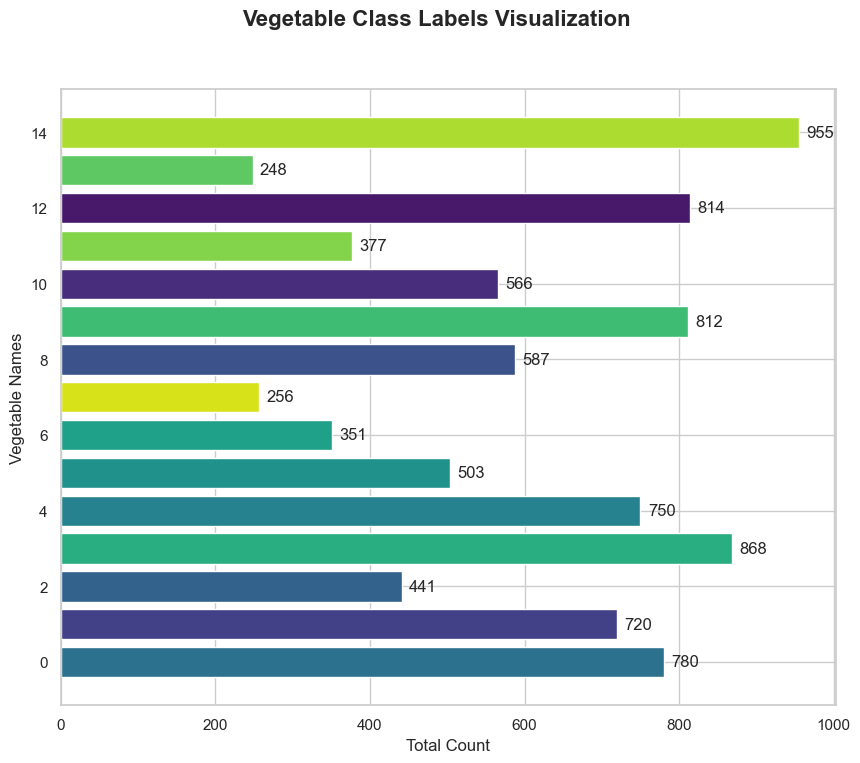

In [49]:
plot_dist(class_counts)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
  - Dataset has Cauliflower as the highest representation at 628
- Dataset has Radish as the lowest representation at 922
- Some form of imbalance dataset can be seen
</ul>
</div>

### Random Image Visualisation

Process of picking random imjages and visualise it
- This provide us a way to inspect our dataset
- To ensure that images are of good qualidty

In [ ]:
def random_image_visualization(X_data, y_data, labels_dict, num_images=10, new=False, size=None):

    # Get a random index here
    random_indices = np.random.choice(X_data.shape[0], num_images, replace=False)
    # Here is to calculate the number of rows
    rows = num_images // 5 + int(num_images % 5 != 0)
    cols = min(num_images, 5)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))

    axes = axes.flatten() if rows > 1 else [axes]

    if new:
        fig.suptitle(f'Random Image Visualisation {size}', fontsize=16, fontweight='bold')
        for idx, ax in enumerate(axes):
            if idx < num_images:
                ax.imshow(X_data[random_indices[idx]], cmap='gray')
                ax.set_title(f"Label: {labels_dict[y_data[random_indices[idx]]]}", fontsize=12)
                ax.axis('off')
            else:
                ax.axis('off') 
    else:
        fig.suptitle(f'Random Image Visualisation ', fontsize=16, fontweight='bold')
        for idx, ax in enumerate(axes):
            if idx < num_images:
                ax.imshow(X_data[random_indices[idx]].astype('uint8'))
                ax.set_title(f"Label: {labels_dict[y_data[random_indices[idx]]]}", fontsize=12)
                ax.axis('off')
            else:
                ax.axis('off') 
    plt.show()


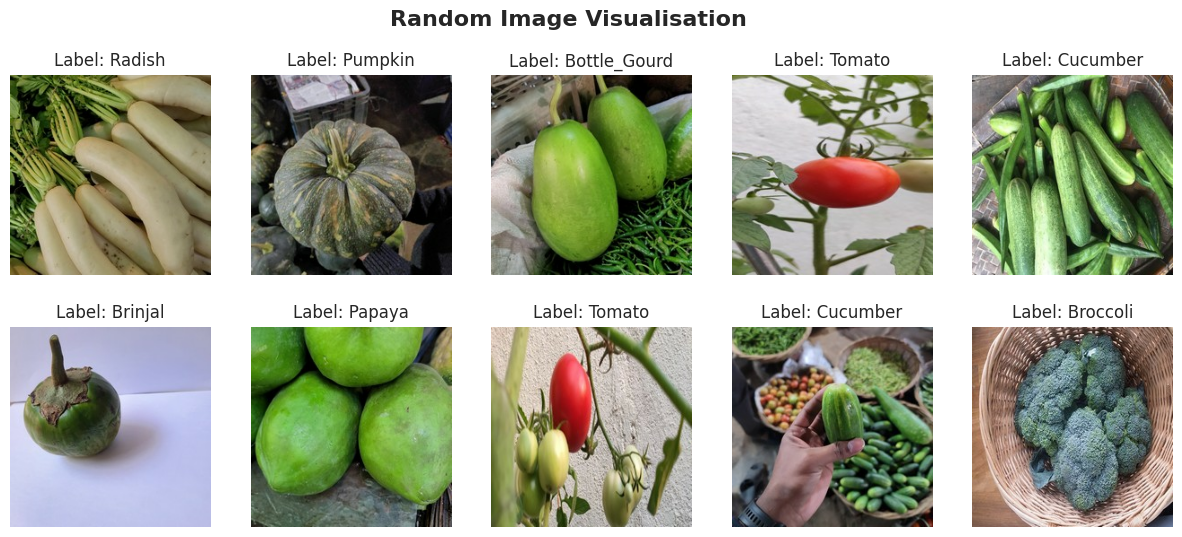

In [ ]:
random_image_visualization(X_train, y_train, labels_dict, new=False)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
 - Dataset are of pretty good quality 
</ul>
</div>

### 35 Image visualisation

Simlar to above random visualisation, this is to
- Ensure the images are of good qualiy
- Check first few images here

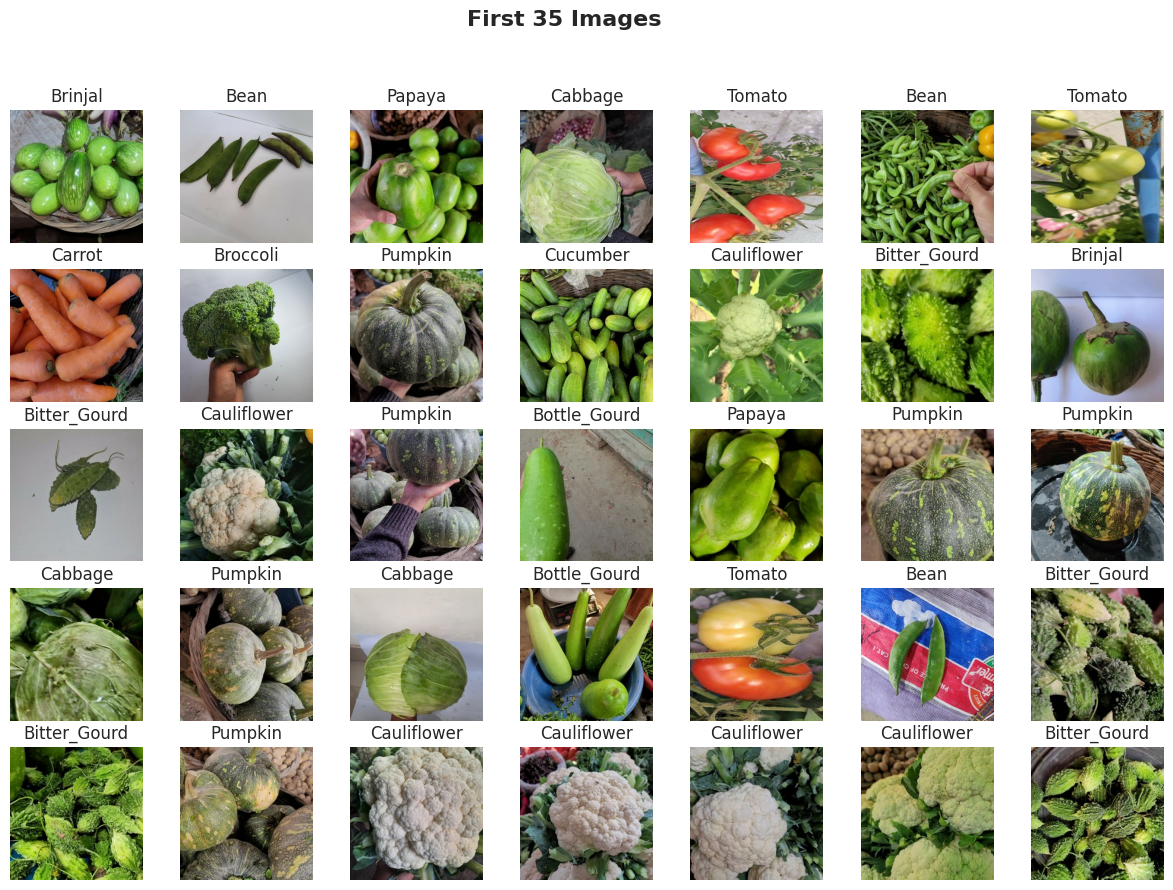

In [ ]:
def visualize_first_images(X_data, y_data, labels, num_images=35, new = False, size=None):
    num_rows = num_images // 7 + (num_images % 7 != 0)
    fig = plt.figure(figsize=(15, 2 * num_rows))

    if new:
        fig.suptitle(f'First 35 Images {size}', fontsize=16, fontweight='bold')
        for i in range(num_images):
            ax = fig.add_subplot(num_rows, 7, i+1)
            ax.imshow(X_data[i], cmap='gray')
            ax.set_title(labels[int(y_data[i])], fontsize=12)
            ax.axis('off')
    
    else:
        fig.suptitle(f'First 35 Images ', fontsize=16, fontweight='bold')
        for i in range(num_images):
            ax = fig.add_subplot(num_rows, 7, i+1)
            ax.imshow(X_data[i].astype('uint8'))
            ax.set_title(labels[int(y_data[i])], fontsize=12)
            ax.axis('off')
        
    plt.show()

visualize_first_images(X_train, y_train, labels_dict)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
- Similar to above, dataset are of pretty good quality 
</ul>
</div>

### Pixel Distribution

To determine which methods to use for scaling of dataset
1. Check for the distribution of the first to iamges 

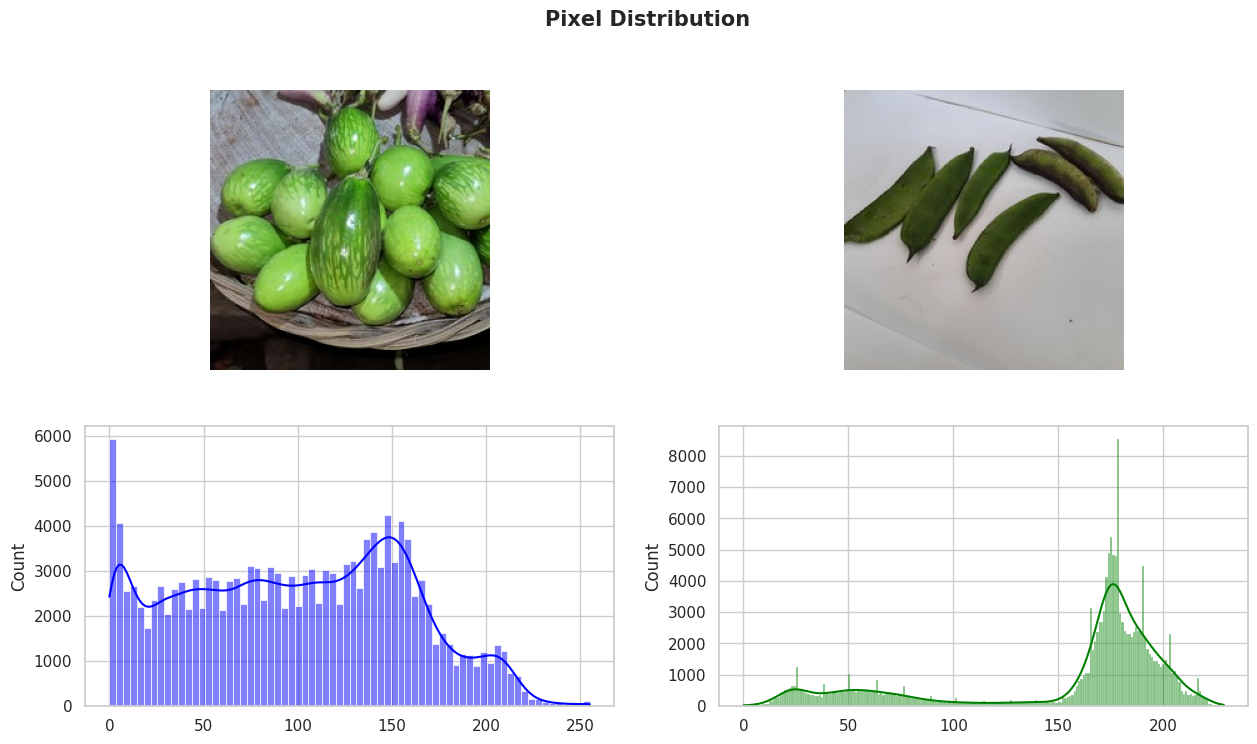

In [ ]:
def visualise_pixel_distribution(X_data, index1, index2):
    fig, ax = plt.subplots(2, 2, figsize=(15, 8))
    fig.suptitle('Pixel Distribution', fontsize=15, fontweight='bold')
    ax[0, 0].imshow(X_data[index1].astype(np.uint8)) # First images
    ax[0, 0].axis('off')
    sns.histplot(X_data[index1].flatten(), ax=ax[1, 0], kde=True, color='blue')
    ax[0, 1].imshow(X_data[index2].astype(np.uint8)) # Second images
    ax[0, 1].axis('off')
    sns.histplot(X_data[index2].flatten(), ax=ax[1, 1], kde=True, color='green')

    plt.show()

visualise_pixel_distribution(X_train, index1=0, index2=1)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

 - First Images
     - Significant variance in colour intensity
     - Contains peaks at 150
     - Wide variation of colour intensity

- Second Images
    - Smaller number of green beans on a light background.
    - Histogram for this image shows a significant peak around the 200 intensity level, which corresponds to the light background
</ul>
</div>

### Mean Pixel Distribution

Checking the mean pixke and standard deviation

In [ ]:
mean, std = np.mean(X_train) ,  np.std(X_train)
print('Mean of Images:', mean)
print('Standard Deviation of Images:', mean)

Mean of Images: 106.97684
Standard Deviation of Images: 106.97684


In [ ]:
y_train.shape

(9028,)

In [ ]:
train_dataset.shape

AttributeError: 'BatchDataset' object has no attribute 'shape'

#### Whole Dataset

In [ ]:
def average_img(X_data):
    average_image = np.mean(X_data.astype(np.uint8), axis=0) / 255
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(average_image)
    ax.set_title('Average Image', fontsize=15, fontweight='bold')
    ax.axis('off')
    plt.show()


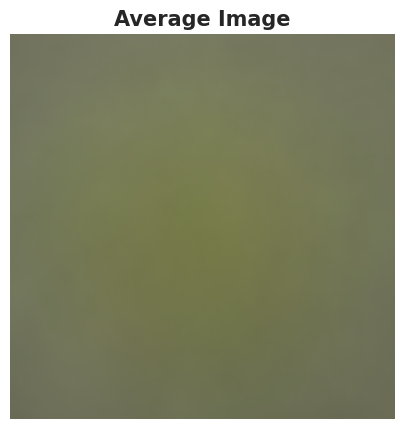

In [ ]:
average_img(X_train)

### By Classs

In [ ]:
def mean_class(X_data):
    fig, ax = plt.subplots(2, 5, figsize=(13, 8))
    fig.suptitle('Mean Pixel By Class', fontsize=15, fontweight='bold')
    for index, axs in enumerate(ax.ravel()):
      average = np.mean(X_data[np.squeeze(y_train == index)],axis=0)
      axs.imshow(average.astype(np.uint8))
      axs.set_title(f'Label: {labels_dict[index]}')
      axs.axis('off')
    plt.show()


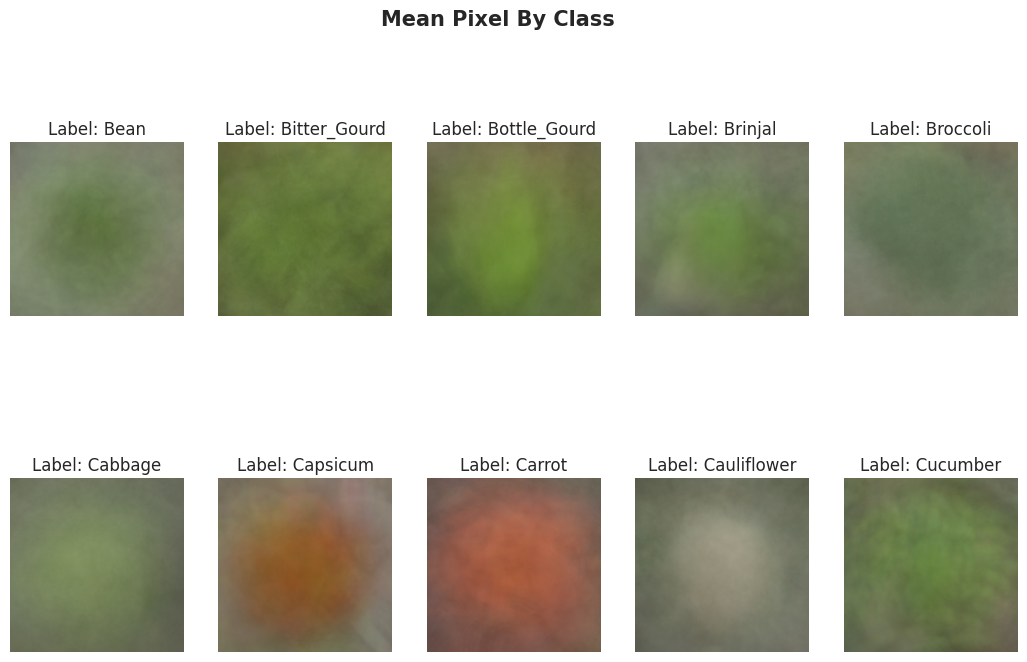

In [ ]:
mean_class(X_train)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
- Overall, the mean image is not as clear here
</ul>
</div>

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Exploratory Data Analysis (31 x 31 Image)__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import the dataset and proceed to do analysis on it

### Importing of data

1. 31 x 31 Images was imported again
2. __Conversion of grayscale was done__

In [35]:
data_small = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/train'  ,
                                                   color_mode='rgb',
                                               image_size=(31,31))
data_small

Found 9028 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 31, 31, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
X_train_small = []
y_train_small = []


for images, labels in tqdm(data_small):
    images = tf.image.rgb_to_grayscale(images)
    X_train_small.append(images)
    y_train_small.append(labels)

X_train_small = np.concatenate(X_train_small, axis=0)
X_train_small = np.squeeze(X_train_small, axis=-1)
y_train_small = np.concatenate(y_train_small, axis=0)

100%|██████████| 283/283 [00:01<00:00, 205.90it/s]


In [37]:
val_data_small = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/validation'  ,
                                                   color_mode='rgb',
                                               image_size=(31,31))
val_data_small

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 31, 31, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
X_val_small = []
y_val_small = []


for images, labels in tqdm(val_data_small):
    images = tf.image.rgb_to_grayscale(images)
    X_val_small.append(images)
    y_val_small.append(labels)

X_val_small = np.concatenate(X_val_small, axis=0)
X_val_small = np.squeeze(X_val_small, axis=-1)
y_val_small = np.concatenate(y_val_small, axis=0)

100%|██████████| 94/94 [00:00<00:00, 187.82it/s]


In [39]:
test_data_small = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/test'  ,
                                                   color_mode='rgb',
                                               image_size=(31,31))
test_data_small

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 31, 31, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [40]:
X_test_small = []
y_test_small = []


for images, labels in tqdm(test_data_small):
    images = tf.image.rgb_to_grayscale(images)
    X_test_small.append(images)
    y_test_small.append(labels)

X_test_small = np.concatenate(X_test_small, axis=0)
X_test_small = np.squeeze(X_test_small, axis=-1)
y_test_small = np.concatenate(y_test_small, axis=0)

100%|██████████| 94/94 [00:00<00:00, 184.67it/s]


### Random Image Visualisation

- Done on the smaller dataset

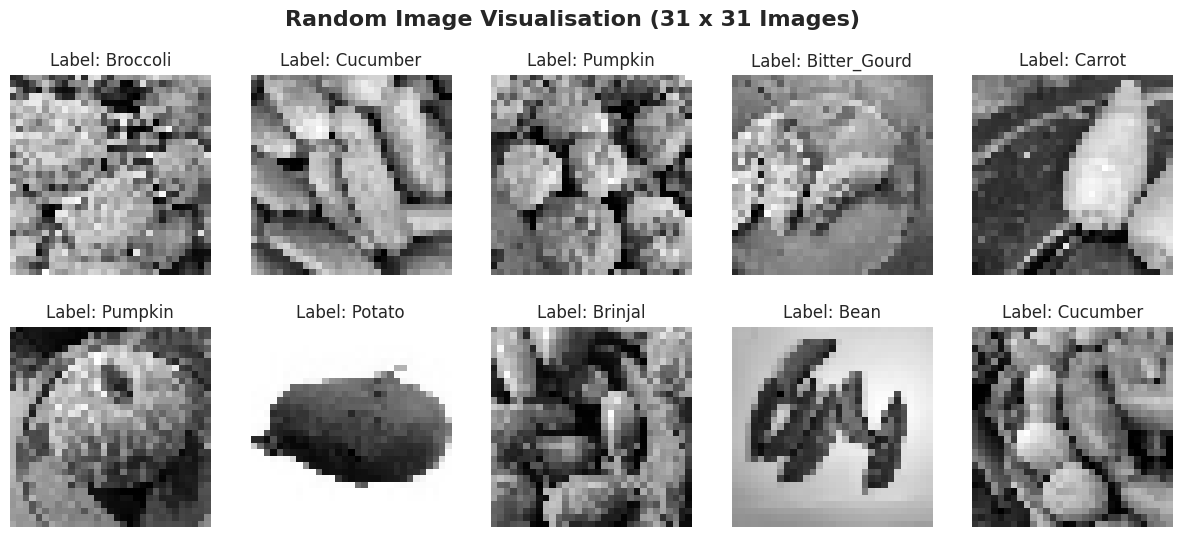

In [ ]:
random_image_visualization(X_train_small, y_train_small, labels_dict, new=True, size='(31 x 31 Images)')

### 35 Image visualisation

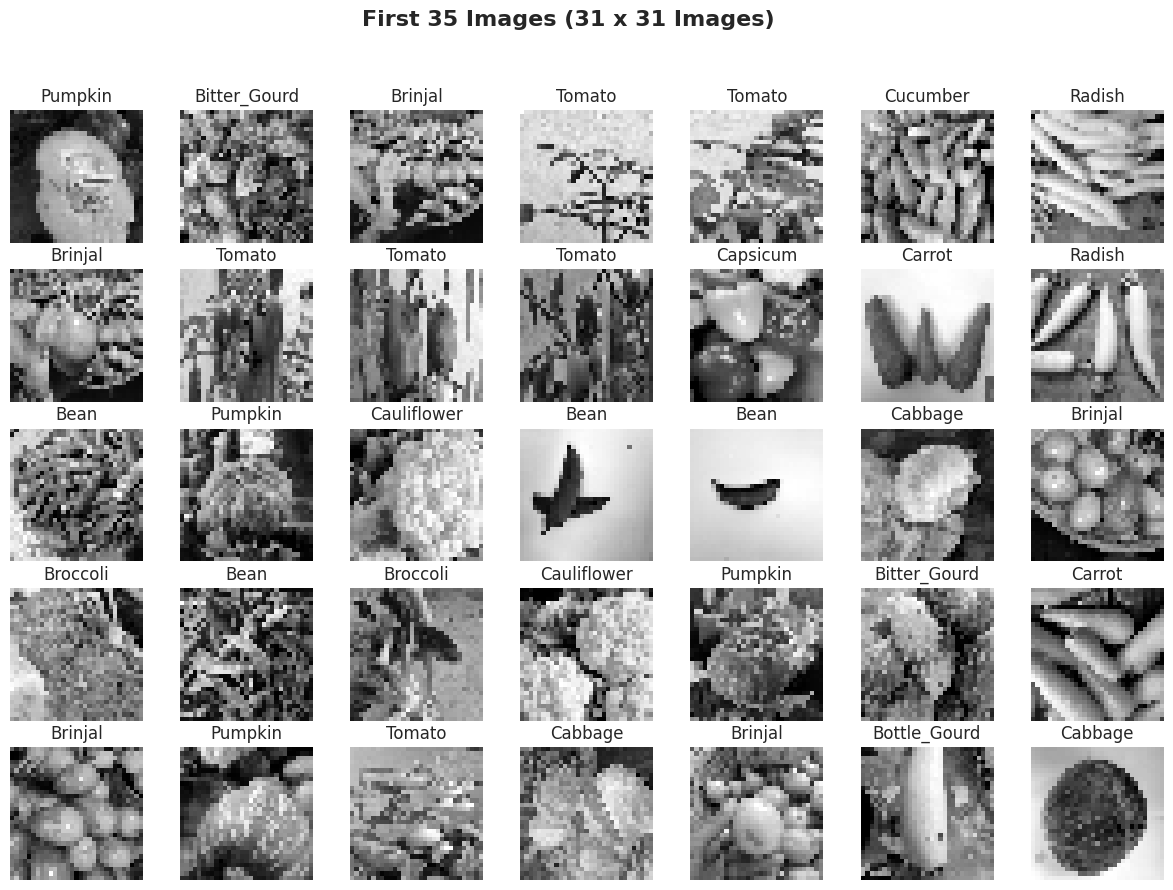

In [ ]:
visualize_first_images(X_train_small, y_train_small, labels_dict, new=True, size='(31 x 31 Images)')

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
- Overall, smaller 31 x31 dataset are of pretty good equality
</ul>
</div>

### Pixel Distribution

- New function was define for this

In [ ]:
def visualise_pixel_distribution2(X_data, index1, index2):
    fig, ax = plt.subplots(2, 2, figsize=(15, 8))
    fig.suptitle('Pixel Distribution', fontsize=15, fontweight='bold')
    ax[0, 0].imshow(X_data[index1], cmap='gray') # First images
    ax[0, 0].axis('off')
    sns.histplot(X_data[index1].flatten(), ax=ax[1, 0], kde=True, color='blue')
    ax[0, 1].imshow(X_data[index2], cmap='gray') # Second images
    ax[0, 1].axis('off')
    sns.histplot(X_data[index2].flatten(), ax=ax[1, 1], kde=True, color='green')
    plt.show()


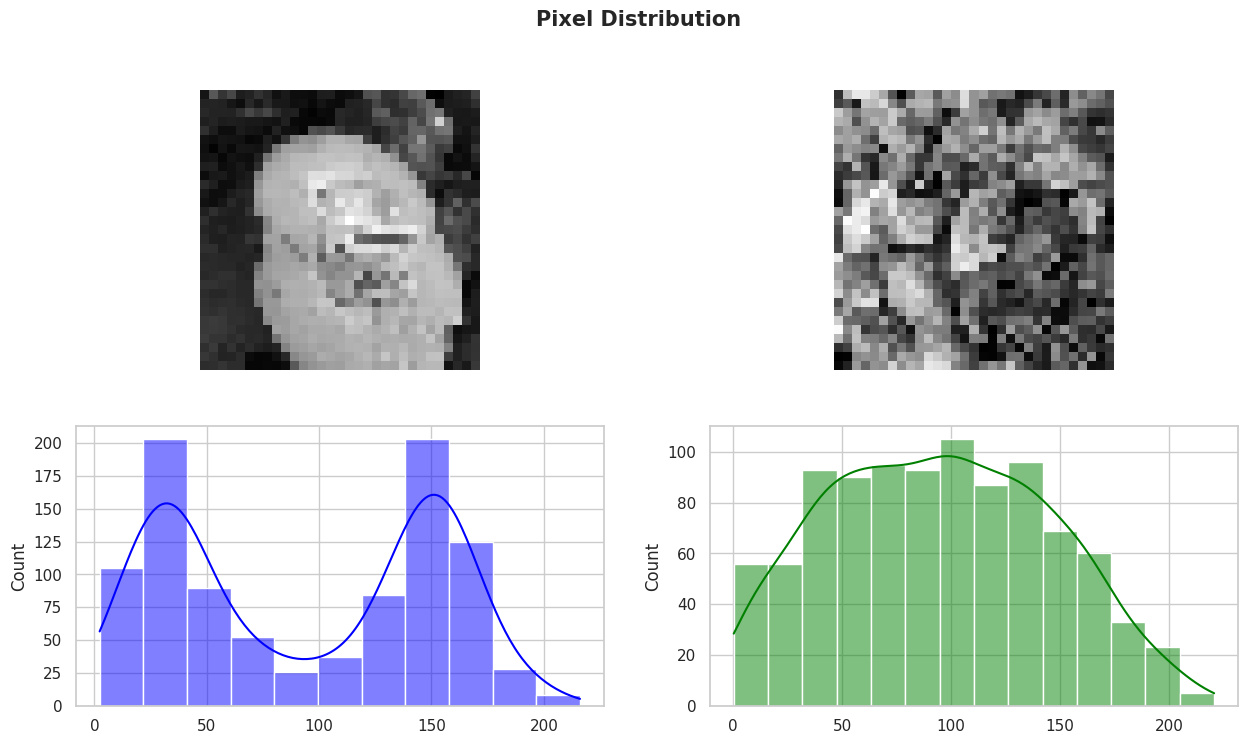

In [ ]:
visualise_pixel_distribution2(X_train_small, index1=0, index2=1)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

 - First Images
     - Follow a normal distribution

- Second Images
    - has two picks here
</ul>
</div>

### Mean Pixel Distribution

Checking the mean pixke and standard deviation

#### Whole dataset

In [ ]:
mean, std = np.mean(X_train_small) ,  np.std(X_train_small)
print('Mean of Images:', mean)
print('Standard Deviation of Images:', mean)

Mean of Images: 114.36305
Standard Deviation of Images: 114.36305


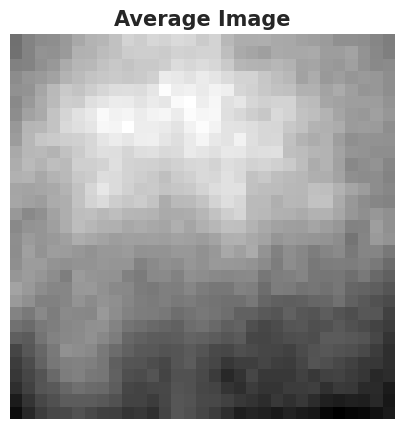

In [ ]:
def average_img(X_data):
    average_image = np.mean(X_data.astype(np.uint8), axis=0) / 255
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(average_image, cmap='gray')
    ax.set_title('Average Image', fontsize=15, fontweight='bold')
    ax.axis('off')
    plt.show()
average_img(X_train_small)

#### By Class

In [ ]:
def mean_class(X_data):
    fig, ax = plt.subplots(2, 5, figsize=(13, 8))
    fig.suptitle('Mean Pixel By Class', fontsize=15, fontweight='bold')
    for index, axs in enumerate(ax.ravel()):
      average = np.mean(X_data[np.squeeze(y_train == index)],axis=0)
      axs.imshow(average, cmap='gray')
      axs.set_title(f'Label: {labels_dict[index]}')
      axs.axis('off')
    plt.show()


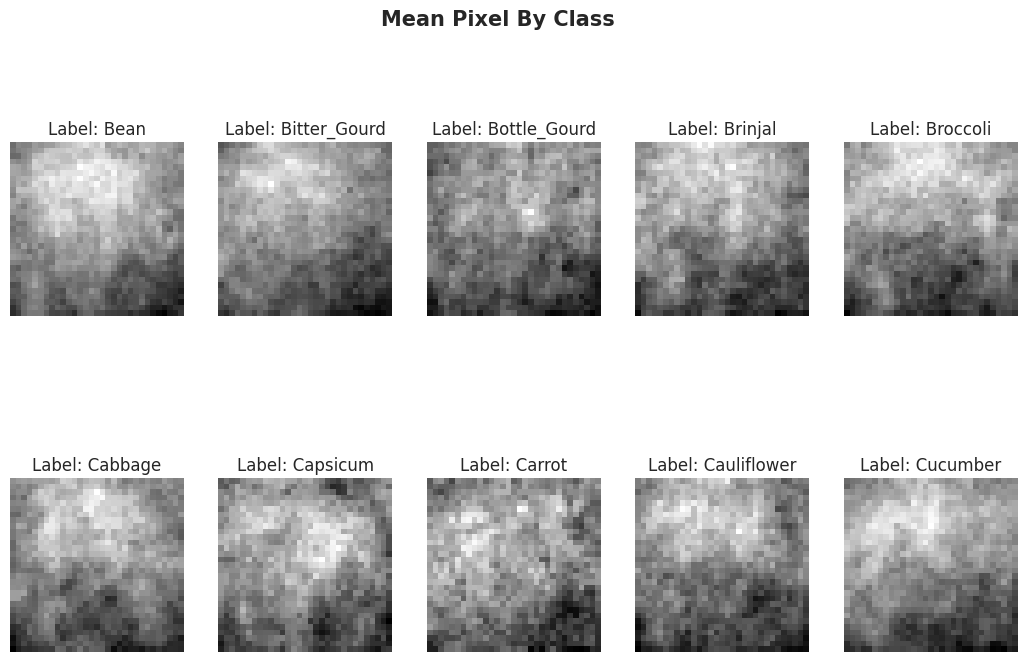

In [ ]:
mean_class(X_train_small)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
- Overall, the mean image is not as clear here
</ul>
</div>

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Exploratory Data Analysis (128 x 128 Image)__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import the dataset and proceed to do analysis on it

In [ ]:
data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/train'  ,
                                                   color_mode='rgb',
                                               image_size=(128,128))
data_big

Found 9028 files belonging to 15 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
X_train_big = []
y_train_big = []


for images, labels in tqdm(data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_train_big.append(images)
    y_train_big.append(labels)

X_train_big = np.concatenate(X_train_big, axis=0)
X_train_big = np.squeeze(X_train_big, axis=-1)
y_train_big = np.concatenate(y_train_big, axis=0)

100%|██████████| 283/283 [00:01<00:00, 211.25it/s]


In [ ]:
val_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/validation'  ,
                                                   color_mode='rgb',
                                               image_size=(128,128))
val_data_big

Found 3000 files belonging to 15 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
X_val_big = []
y_val_big = []


for images, labels in tqdm(val_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_val_big.append(images)
    y_val_big.append(labels)

X_val_big = np.concatenate(X_val_big, axis=0)
X_val_big = np.squeeze(X_val_big, axis=-1)
y_val_big = np.concatenate(y_val_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 187.41it/s]


In [ ]:
test_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/test'  ,
                                                   color_mode='rgb',
                                               image_size=(128,128))
test_data_big

Found 3000 files belonging to 15 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
X_test_big = []
y_test_big = []


for images, labels in tqdm(test_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_test_big.append(images)
    y_test_big.append(labels)

X_test_big = np.concatenate(X_test_big, axis=0)
X_test_big = np.squeeze(X_test_big, axis=-1)
y_test_big = np.concatenate(y_test_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 185.17it/s]


### Random Image Visualisation

- Done on the bigger dataset

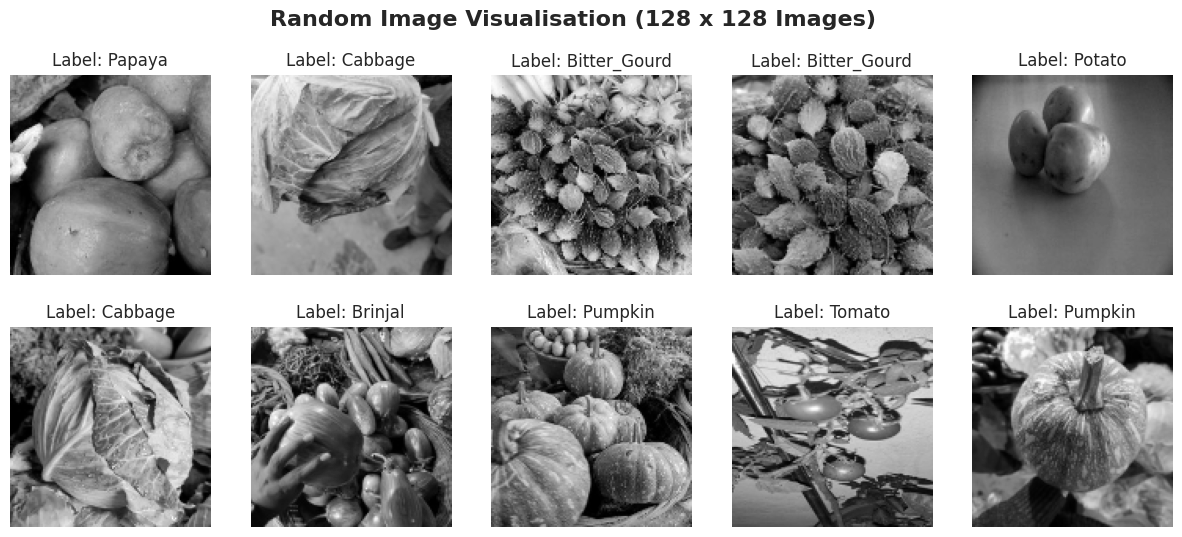

In [ ]:
random_image_visualization(X_train_big, y_train_big, labels_dict, new=True, size='(128 x 128 Images)')

### 35 Image visualisation

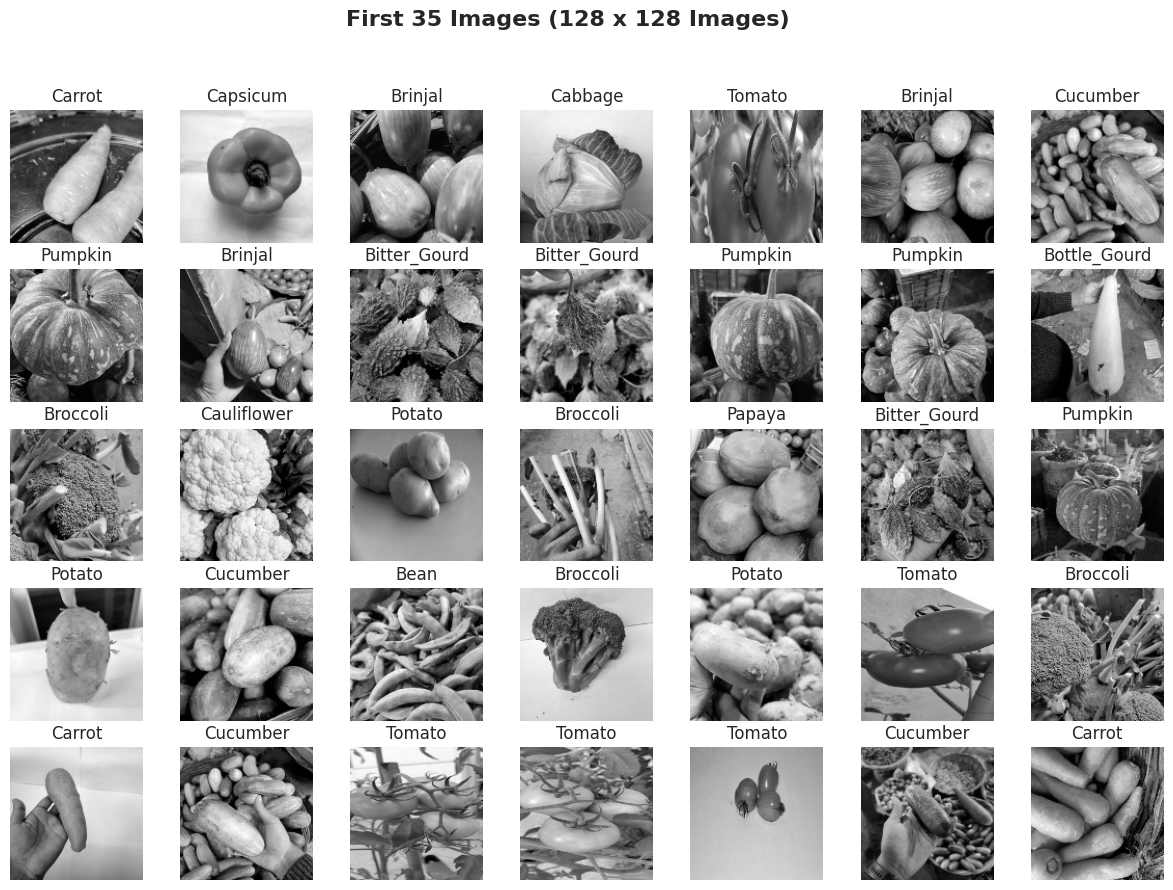

In [ ]:
visualize_first_images(X_train_big, y_train_big, labels_dict, new=True, size='(128 x 128 Images)')

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>
    
- Overall, smaller 31 x31 dataset are of clear and good quality
</ul>
</div>

### Pixel Distribution

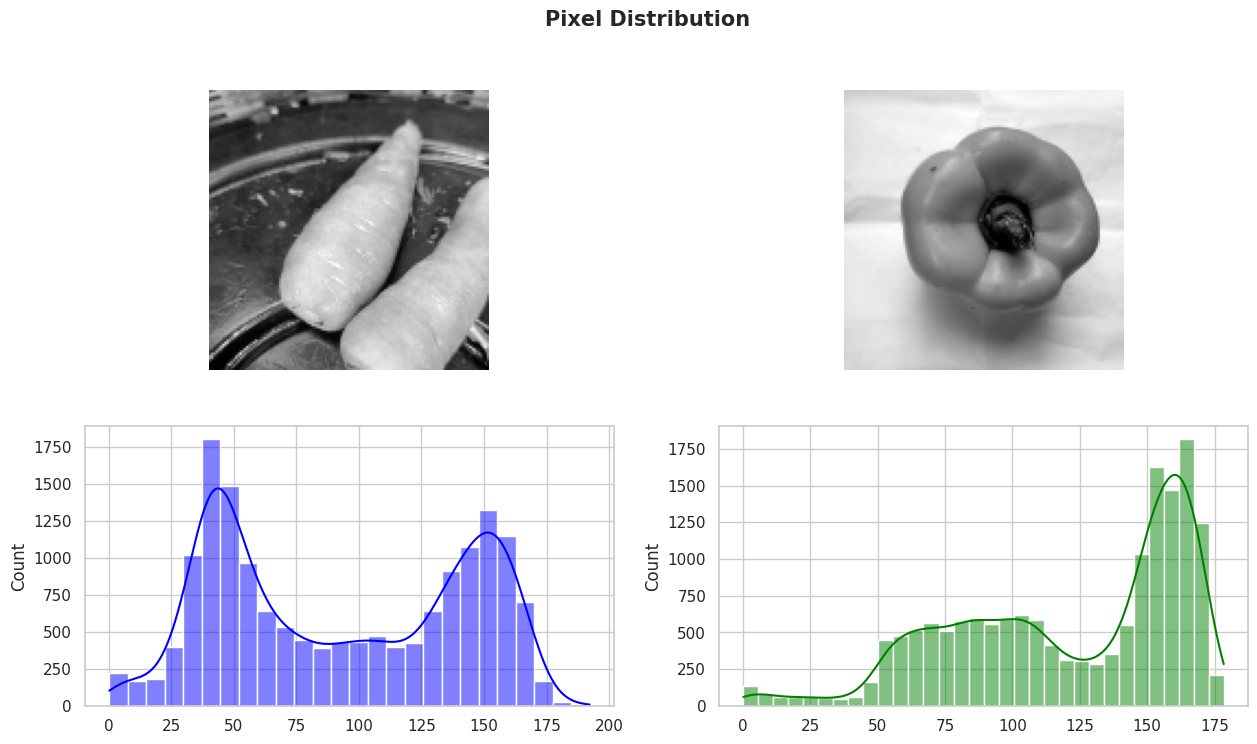

In [ ]:
visualise_pixel_distribution2(X_train_big, index1=0, index2=1)

<div class="alert alert-block"
style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

 - First Images
     - First peak at the lower end of the intensity scale (dark pixels), meaning that a significant portion of the image contains dark areas.
     - Ssecond peak is around the mid-range of the intensity scale,showing thatg another substantial part of the image has medium brightne
- Second Images
     - First peak at the lower end, indicating the presence of dark pixels, not as huge as second one
     - Secondr peak is towards the higher end of the intensity scale, suggesting a large number of bright pixel
</u>l>
</div>

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Overall__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

The above exploratory data analysis is done on original, 31 x 31 and 128 x 128, next we can start developing our model